# Create a logistic regression model to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad


/home/ktt/anaconda2/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ktt/anaconda2/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = 'BRAF'

In [4]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 500
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [5]:
if not os.path.exists('data'):
    os.makedirs('data')

In [6]:
url_to_path = {
    # X matrix
    'https://ndownloader.figshare.com/files/5514386':
        os.path.join('data', 'expression.tsv.bz2'),
    # Y Matrix
    'https://ndownloader.figshare.com/files/5514389':
        os.path.join('data', 'mutation-matrix.tsv.bz2'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

In [7]:
%%time
path = os.path.join('data', 'expression.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 2min 29s, sys: 1.46 s, total: 2min 30s
Wall time: 2min 31s


In [8]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 2min 5s, sys: 2.44 s, total: 2min 7s
Wall time: 2min 7s


In [10]:
y = Y[GENE]

In [11]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    0
TCGA-02-2483-01    0
TCGA-02-2485-01    0
TCGA-02-2486-01    0
TCGA-04-1348-01    0
Name: BRAF, dtype: int64

In [12]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.91007
1    0.08993
Name: BRAF, dtype: float64

## Set aside 10% of the data for testing

In [13]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,501 features, 6,935 training samples, 771 testing samples'

## Median absolute deviation feature selection

In [14]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)

## Define pipeline and Cross validation model fitting

In [15]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
clf = SGDClassifier(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [16]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features

CPU times: user 19.8 s, sys: 5.31 s, total: 25.1 s
Wall time: 47.3 s


In [17]:
clf_grid.best_params_

{'alpha': 0.1, 'l1_ratio': 0.05}

In [18]:
best_clf

SGDClassifier(alpha=0.1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.05,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=0, shuffle=True,
       verbose=0, warm_start=False)

## Visualize hyperparameters performance

In [19]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [20]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

,alpha,fold,l1_ratio,score
0,0.000001,0,0.0,0.863679
1,0.000001,1,0.0,0.918601


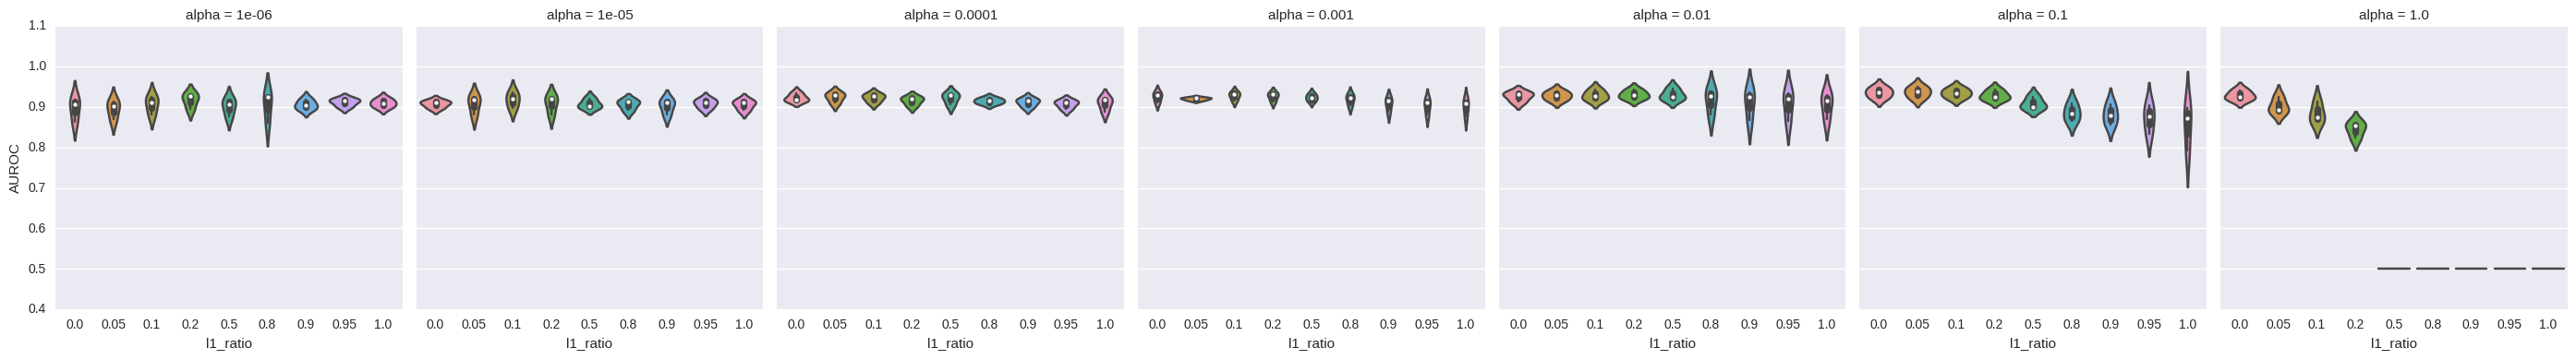

In [21]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='l1_ratio', y='score', col='alpha',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('AUROC');

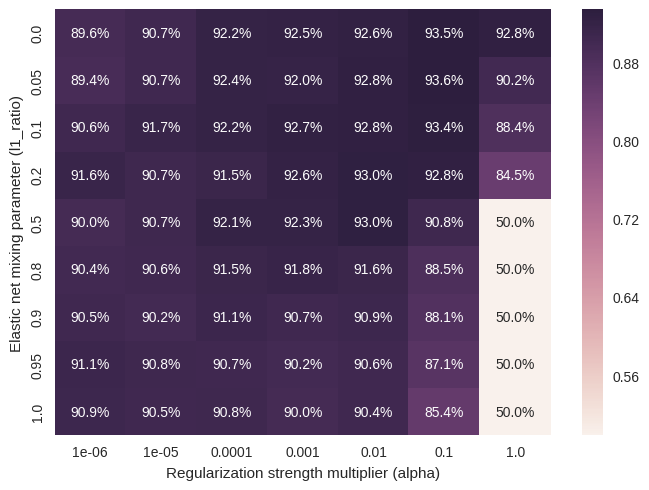

In [22]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='l1_ratio', columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [23]:
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

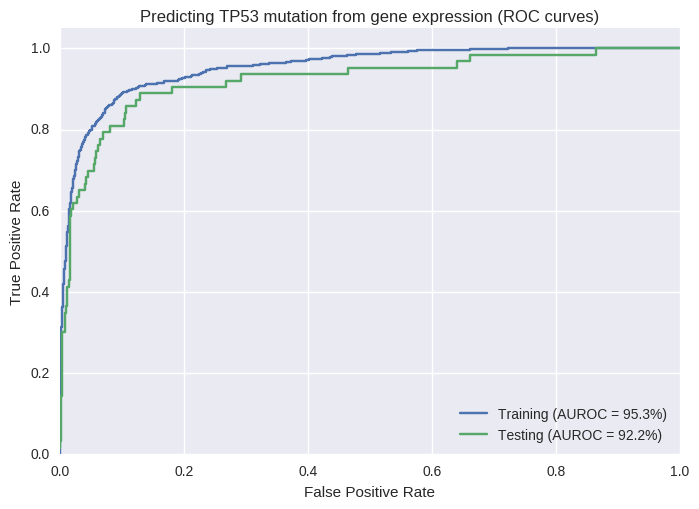

In [24]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In [25]:
coef_df = pd.DataFrame(best_clf.coef_.transpose(), index=X.columns[feature_mask], columns=['weight'])
coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [26]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'61.4% zero coefficients; 97 negative and 96 positive coefficients'

In [27]:
coef_df.head(10)

,weight,abs
STK32A,0.167468,0.167468
LYPD6B,-0.164757,0.164757
CAPN13,-0.152262,0.152262
GFRA1,-0.140171,0.140171
ODZ2,-0.135157,0.135157
AR,-0.134197,0.134197
CHL1,0.132811,0.132811
HOXB13,0.131592,0.131592
CCL18,0.130493,0.130493
KRT23,-0.129755,0.129755


The results are not surprising. TP53 is a transcription modulator and when it mutated in a tumor, the cell goes haywire. This makes finding a transcriptional signature fairly easy. Also, the genes that the classifier uses is interesting, but not necessarily novel.

1. TP53 is a [transcription factor](https://en.wikipedia.org/wiki/Transcription_factor "TF wiki") that regulates many genes including EDA2R. Studies have linked EDA2R (or XEDAR) to [increased survival in colon cancer patients](http://www.ncbi.nlm.nih.gov/pubmed/19543321) and [losing hair as a result of chemotherapy](http://onlinelibrary.wiley.com/doi/10.1016/j.febslet.2010.04.058/full)
2. SPATA18 is a gene associated with spermatogenesis and is a transcription factor for TP53. It's association with TP53 was [recently discovered](http://www.ncbi.nlm.nih.gov/pubmed/21300779) in 2011.
3. C6orf138 (or [PTCHD4](http://www.genecards.org/cgi-bin/carddisp.pl?gene=PTCHD4)) is also a transcriptional target for TP53 and was only recently discovered in [2014 to repress hedgehog signalling](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4239647/).
4. The list goes on and includes several other TP53 targets...

## Investigate the predictions

In [28]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', pipeline.decision_function(X)),
    ('probability', pipeline.predict_proba(X)[:, 1]),
])
predict_df['probability_str'] = predict_df['probability'].apply('{:.1%}'.format)

In [29]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-DE-A0Y2-01,TCGA-DE-A0Y2-01,0,0,3.744189,0.976892,97.7%
TCGA-ET-A3BN-01,TCGA-ET-A3BN-01,1,0,3.599396,0.973387,97.3%
TCGA-DJ-A2PO-01,TCGA-DJ-A2PO-01,0,0,3.591521,0.973183,97.3%
TCGA-FR-A3YN-06,TCGA-FR-A3YN-06,0,0,3.512757,0.971049,97.1%
TCGA-ET-A2MX-01,TCGA-ET-A2MX-01,0,0,3.463540,0.969632,97.0%
TCGA-DA-A95X-06,TCGA-DA-A95X-06,0,0,3.225092,0.961768,96.2%
TCGA-D3-A5GO-06,TCGA-D3-A5GO-06,0,0,3.224241,0.961736,96.2%
TCGA-DE-A69K-01,TCGA-DE-A69K-01,0,0,3.115459,0.957526,95.8%
TCGA-D3-A8GP-06,TCGA-D3-A8GP-06,0,0,3.088631,0.956421,95.6%


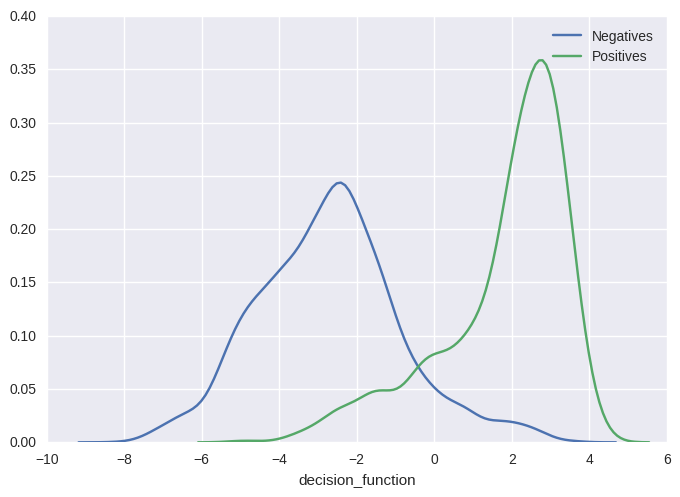

In [30]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')

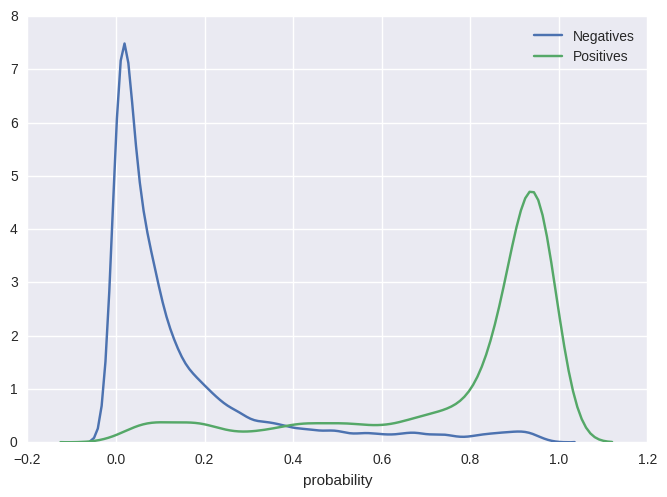

In [31]:
ax = sns.distplot(predict_df.query("status == 0").probability, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").probability, hist=False, label='Positives')